In [76]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import datetime
import pickle
import nltk
import sklearn
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# load in tweets
with open('../data/pickled_tweets_corpus/4seasons_home_unigrams.pkl', 'rb') as f:
    home_tweets = pickle.load(f)
with open('../data/pickled_tweets_corpus/4seasons_away_unigrams.pkl', 'rb') as f:
    away_tweets = pickle.load(f)

# load in nfl data
s1 = pd.read_csv('../data/season_data/2020_all_data.csv', index_col=0)
s2 = pd.read_csv('../data/season_data/2019_all_data.csv', index_col=0)
s3 = pd.read_csv('../data/season_data/2018_all_data.csv', index_col=0)
s4 = pd.read_csv('../data/season_data/2017_all_data.csv', index_col=0)
full = pd.concat([s4,s3,s2,s1],axis=0)
full['Datetime'] = pd.DatetimeIndex(full['Datetime'], tz='US/Eastern')
full['Datetime'] = full['Datetime'].dt.tz_convert('UTC')
full['Home'] = np.where(full['Home'] == 'Washington Redskins', 'Washington Football Team', full['Home'])
full['Away'] = np.where(full['Away'] == 'Washington Redskins', 'Washington Football Team', full['Away'])
full['Home'] = np.where(full['Home'] == 'San Diego Chargers', 'Los Angeles Chargers', full['Home'])
full['Away'] = np.where(full['Away'] == 'San Diego Chargers', 'Los Angeles Chargers', full['Away'])
full['Home'] = np.where(full['Home'] == 'St Louis Rams', 'Los Angeles Rams', full['Home'])
full['Away'] = np.where(full['Away'] == 'St Louis Rams', 'Los Angeles Rams', full['Away'])
full['Home'] = np.where(full['Home'] == 'Oakland Raiders', 'Las Vegas Raiders', full['Home'])
full['Away'] = np.where(full['Away'] == 'Oakland Raiders', 'Las Vegas Raiders', full['Away'])

In [3]:
from collections import Counter
def vectorize_list(list_of_tweets, corpus):
    num_tweets = len(list_of_tweets)
    lol = [x.split() for x in list_of_tweets]
    with_repeats = [item for sublist in lol for item in sublist]
    counts = dict(Counter(with_repeats))
    to_return = []
    for key in corpus:
        num = counts[key]/num_tweets if key in counts else 0
        to_return.append(num)
    return to_return

In [4]:
# count unigrams
def count_unigrams(tweet, corpus):
    words = tweet.split(" ")
    for word in words:
        if word in corpus:
            corpus[word] += 1
        else:
            corpus[word] = 1

In [5]:
#Create the home/away corpus
home_corpus = {}
away_corpus = {}
counter = 0
for tweets in home_tweets:
    if counter >= 768:
        break
    for tw in tweets:
        count_unigrams(tw,home_corpus)
    counter += 1

counter = 0
for tweets in away_tweets:
    if counter >= 768:
        break
    for tw in tweets:
        count_unigrams(tw,away_corpus)
    counter += 1

In [6]:
#Define a list of stopwords to remove.
stopwords = nltk.corpus.stopwords.words("english")

In [7]:
# remove words with <= 2 characters, stopwords, hashtags
for key in list(home_corpus.keys()):
    if len(key) <= 2:
        del home_corpus[key]
    elif key in stopwords:
        del home_corpus[key]
    elif key[0] == '#':
        del home_corpus[key]

for key in list(away_corpus.keys()):
    if len(key) <= 2:
        del away_corpus[key]
    elif key in stopwords:
        del away_corpus[key]
    elif key[0] == '#':
        del away_corpus[key]

In [8]:
#Turns a list of tweets (for one team, for one game)
#into a vector using the top_grams
from collections import Counter
def vectorize_list(list_of_tweets, corpus):
    num_tweets = len(list_of_tweets)
    lol = [x.split() for x in list_of_tweets]
    with_repeats = [item for sublist in lol for item in sublist]
    counts = dict(Counter(with_repeats))
    to_return = []
    for key in corpus:
        num = np.log(1+counts[key]) if key in counts else 0
        to_return.append(num)
    return to_return

In [53]:
# get number of tweets for all home and away teams
n_home_tweets = sum([len(game_tweets) for game_tweets in home_tweets])
n_away_tweets = sum([len(game_tweets) for game_tweets in away_tweets])

In [63]:
# get the unigrams that appear in at least 0.1% of home/away tweets
home_top_grams = [word for word in home_corpus if home_corpus[word] > n_home_tweets*0.001]
away_top_grams = [word for word in away_corpus if away_corpus[word] > n_away_tweets*0.001]

In [64]:
# TRAIN SET
#Create lists of vectors for home, away games
num_h_tweets = [vectorize_list(game, home_top_grams) for game in home_tweets[:768]]
num_a_tweets = [vectorize_list(game, away_top_grams) for game in away_tweets[:768]]

#Turn into arrays
home_vecs = np.array(num_h_tweets)
away_vecs = np.array(num_a_tweets)

#Concatenate home, away to form input matrix.
X_train = np.concatenate([home_vecs, away_vecs], axis=1)

# TEST SET
#Create lists of vectors for home, away games
num_h_tweets = [vectorize_list(game, home_top_grams) for game in home_tweets[768:]]
num_a_tweets = [vectorize_list(game, away_top_grams) for game in away_tweets[768:]]

#Turn into arrays
home_vecs = np.array(num_h_tweets)
away_vecs = np.array(num_a_tweets)

#Concatenate home, away to form input matrix.
X_test = np.concatenate([home_vecs, away_vecs], axis=1)

In [65]:
Y_train = np.array(full["Home Win"])[:768]
Y_test = np.array(full["Home Win"])[768:]

In [67]:
# Basic classifiers on full data
lr = LogisticRegression(penalty="l1",solver="liblinear",C=0.1)
lr.fit(X_train, Y_train)
print(lr.score(X_test, Y_test))

ada = AdaBoostClassifier(n_estimators=1000)
ada.fit(X_train, Y_train)
print(ada.score(X_test, Y_test))

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, Y_train)
print(rf.score(X_test, Y_test))

mlp = MLPClassifier(max_iter=10000)
mlp.fit(X_train, Y_train)
print(mlp.score(X_test, Y_test))

gnb = GaussianNB()
gnb.fit(X_train, Y_train)
print(gnb.score(X_test, Y_test))

0.5390625
0.46875
0.53125
0.48046875
0.5078125


<BarContainer object of 5 artists>

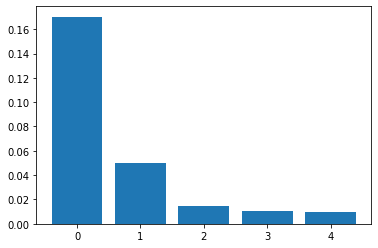

In [68]:
# Use PCA to reduce dimensions of X to 10 components
n = 5
pca = sklearn.decomposition.PCA(n_components=n)
pca.fit(X_train)
plt.bar(x=range(n),height=pca.explained_variance_ratio_)

In [69]:
reduced_X_train = pca.transform(X_train)
reduced_X_test = pca.transform(X_test)

In [90]:
# Basic classifiers on reduced data
lr = LogisticRegression(penalty="l1",solver="liblinear",C=0.1)
lr.fit(reduced_X_train, Y_train)
print(np.mean(sklearn.model_selection.cross_val_score(lr,reduced_X_train,Y_train,cv=10)))

ada = AdaBoostClassifier(n_estimators=5)
ada.fit(reduced_X_train, Y_train)
print(np.mean(sklearn.model_selection.cross_val_score(ada,reduced_X_train,Y_train,cv=10)))

rf = RandomForestClassifier(n_estimators=10)
rf.fit(reduced_X_train, Y_train)
print(np.mean(sklearn.model_selection.cross_val_score(rf,reduced_X_train,Y_train,cv=10)))

mlp = MLPClassifier(max_iter=10000)
mlp.fit(reduced_X_train, Y_train)
print(np.mean(sklearn.model_selection.cross_val_score(mlp,reduced_X_train,Y_train,cv=10)))

gnb = GaussianNB()
gnb.fit(reduced_X_train, Y_train)
print(np.mean(sklearn.model_selection.cross_val_score(gnb,reduced_X_train,Y_train,cv=10)))

0.5598940533151058
0.5427887901572113
0.5000683526999316
0.5300068352699931
0.5468386876281613
